In [4]:
import openml
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# 47 -> tae 48 
#2079 -> eucalyptus 188
# 3561 -> profb 470
dataset_ids  = [11, 48, 470, 5, 7, 188, 163, 4, 477, 34 ,875]
results = []

In [9]:
# Define parameter grids for each model
param_grid = {
    "Logistic Regression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    "Random Forest": {
        'model__n_estimators': [10, 100, 1000],
        'model__max_features': [None, 'sqrt', 'log2']
    },
    "SVM": {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
}

In [10]:
for dataset_id in dataset_ids:
    # Load the dataset
    dataset = openml.datasets.get_dataset(dataset_id, 
                                          download_data = True, 
                                          download_qualities =True, 
                                          download_features_meta_data=True
                                         )
    print(dataset)

OpenML Dataset
Name..........: balance-scale
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:19:55
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/11/balance-scale.arff
OpenML URL....: https://www.openml.org/d/11
# of features.: 5
# of instances: 625
OpenML Dataset
Name..........: tae
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:53
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/48/tae.arff
OpenML URL....: https://www.openml.org/d/48
# of features.: 6
# of instances: 151
OpenML Dataset
Name..........: profb
Version.......: 1
Format........: ARFF
Upload Date...: 2014-09-28 23:51:27
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/52582/profb.arff
OpenML URL....: https://www.openml.org/d/470
# of features.: 10
# of instances: 672
OpenML Dataset
Name..........: arrhythmia
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:19:36
Licen

In [44]:
# Loop through each dataset ID
dataset_results = None

for dataset_id in dataset_ids:
    # Load the dataset
    dataset = openml.datasets.get_dataset(dataset_id, 
                                          download_data = True, 
                                          download_qualities =True, 
                                          download_features_meta_data=True
                                         )
    print(dataset.name)
    
    X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    
    # Create train-test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist() 

    # Create transformers for the numerical and categorical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
        ('scaler', StandardScaler())  # Scale data
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
        ('oe', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)) 
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    # Define models to test
    models = {
        "Logistic Regression": Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', LogisticRegression())
            ]),
        "Random Forest": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier())
        ]),
        "SVM": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', SVC())
        ])
    }
    model_results = None
    
    # Loop through each model
    for model_name, model in models.items():
        # Setup the GridSearchCV pipeline
        grid_search = GridSearchCV(model, param_grid=param_grid[model_name], cv=5, scoring='accuracy', return_train_score=True)
        grid_search.fit(X_train, y_train)

        if model_results is None:
            model_results = pd.DataFrame(grid_search.cv_results_)
            model_results["Model"] = model_name
        else:
            dataframe = pd.DataFrame(grid_search.cv_results_)
            dataframe["Model"] = model_name
            model_results = pd.concat([model_results, dataframe], axis = 0)
        
        # Predict the test set
        y_pred = grid_search.best_estimator_.predict(X_test)
        
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store the results
        results.append({
            'dataset_id': dataset_id,
            'dataset_name': dataset.name,
            'model': model_name,
            'best_params': grid_search.best_params_,
            'accuracy': accuracy
        })

    if dataset_results is None:
        dataset_results = model_results
        dataset_results["Dataset"] = dataset.name
    else:
        dataframe = model_results
        dataframe["Dataset"] = dataset.name
        dataset_results = pd.concat([dataset_results, dataframe], axis = 0)

balance-scale


C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit

ecoli


C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\loris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\loris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

heart-c


C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit

soybean


C:\Users\loris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\loris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SyskillWebert-Goats


C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\loris\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", 

In [45]:
dataset_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,Model,param_model__max_features,param_model__n_estimators,param_model__kernel,Dataset
0,0.009804,0.001464,0.002806,7.688471e-04,0.1,lbfgs,"{'model__C': 0.1, 'model__solver': 'lbfgs'}",0.872340,0.914894,0.851064,...,0.906417,0.888000,0.885333,0.890496,0.008051,Logistic Regression,NaN,NaN,NaN,balance-scale
1,0.006399,0.001855,0.002399,4.885526e-04,0.1,liblinear,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.861702,0.904255,0.851064,...,0.903743,0.888000,0.888000,0.889959,0.007220,Logistic Regression,NaN,NaN,NaN,balance-scale
2,0.009588,0.001620,0.003402,1.022491e-03,1,lbfgs,"{'model__C': 1, 'model__solver': 'lbfgs'}",0.851064,0.914894,0.851064,...,0.901070,0.888000,0.882667,0.888893,0.006391,Logistic Regression,NaN,NaN,NaN,balance-scale
3,0.005610,0.000494,0.002393,4.893058e-04,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.851064,0.904255,0.851064,...,0.898396,0.888000,0.885333,0.889426,0.004889,Logistic Regression,NaN,NaN,NaN,balance-scale
4,0.009602,0.000490,0.002201,4.096259e-04,10,lbfgs,"{'model__C': 10, 'model__solver': 'lbfgs'}",0.861702,0.914894,0.861702,...,0.917112,0.888000,0.880000,0.899589,0.016930,Logistic Regression,NaN,NaN,NaN,balance-scale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.005599,0.000799,0.002600,4.901155e-04,1,NaN,"{'model__C': 1, 'model__kernel': 'sigmoid'}",0.545455,0.454545,0.400000,...,0.547619,0.476190,0.571429,0.528804,0.039128,SVM,NaN,NaN,sigmoid,SyskillWebert-Goats
8,0.011998,0.001789,0.002802,4.004717e-04,10,NaN,"{'model__C': 10, 'model__kernel': 'linear'}",0.545455,0.545455,0.400000,...,0.690476,0.690476,0.642857,0.653542,0.038769,SVM,NaN,NaN,linear,SyskillWebert-Goats
9,0.024999,0.023177,0.003002,1.343632e-06,10,NaN,"{'model__C': 10, 'model__kernel': 'poly'}",0.545455,0.545455,0.600000,...,0.761905,0.619048,0.666667,0.663182,0.051754,SVM,NaN,NaN,poly,SyskillWebert-Goats
10,0.005401,0.000491,0.002000,2.611745e-07,10,NaN,"{'model__C': 10, 'model__kernel': 'rbf'}",0.454545,0.454545,0.400000,...,0.738095,0.690476,0.761905,0.730778,0.027706,SVM,NaN,NaN,rbf,SyskillWebert-Goats


In [46]:
for result in results:
    print(f"Dataset ID: {result['dataset_id']} - {result['dataset_name']}\n"
          f"Model: {result['model']}\nBest Params: {result['best_params']}\n"
          f"Accuracy: {result['accuracy']:.2f}\n")

Dataset ID: 11 - balance-scale
Model: Logistic Regression
Best Params: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Accuracy: 0.85

Dataset ID: 11 - balance-scale
Model: Random Forest
Best Params: {'model__max_features': 'sqrt', 'model__n_estimators': 1000}
Accuracy: 0.81

Dataset ID: 11 - balance-scale
Model: SVM
Best Params: {'model__C': 10, 'model__kernel': 'rbf'}
Accuracy: 0.94

Dataset ID: 39 - ecoli
Model: Logistic Regression
Best Params: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Accuracy: 0.90

Dataset ID: 39 - ecoli
Model: Random Forest
Best Params: {'model__max_features': 'sqrt', 'model__n_estimators': 1000}
Accuracy: 0.90

Dataset ID: 39 - ecoli
Model: SVM
Best Params: {'model__C': 1, 'model__kernel': 'linear'}
Accuracy: 0.87

Dataset ID: 11 - balance-scale
Model: Logistic Regression
Best Params: {'model__C': 0.1, 'model__solver': 'lbfgs'}
Accuracy: 0.85

Dataset ID: 11 - balance-scale
Model: Random Forest
Best Params: {'model__max_features': 'sqrt', 'model__n_estimators': 1

balance-scale


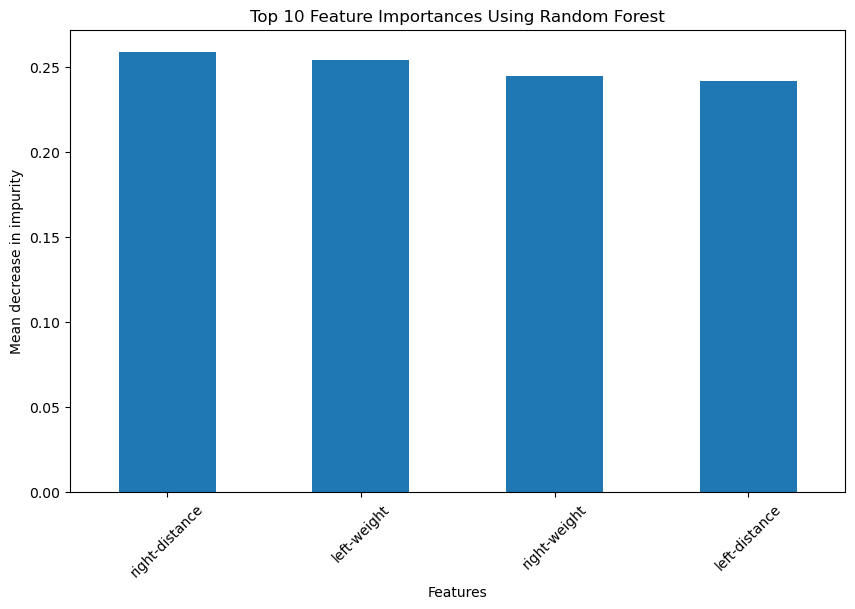

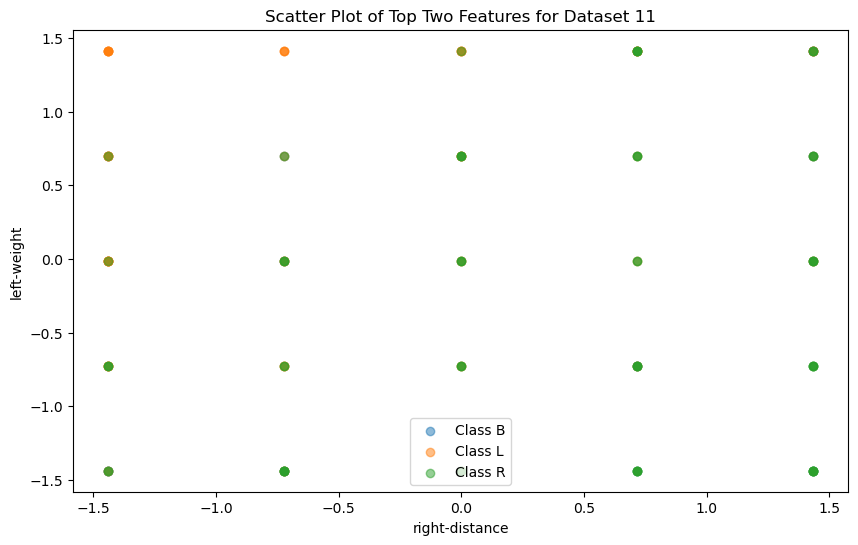

pollen


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [17]:
for dataset_id in dataset_ids:
    dataset = openml.datasets.get_dataset(dataset_id, 
                                          download_data = True, 
                                          download_qualities =True, 
                                          download_features_meta_data=True
                                         )

    print(dataset.name)
    
    X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Identify categorical and numerical columns
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('oe', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1))])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)])

    # Define the model
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(random_state=42))])
    
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get feature importances
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
    else:
        importances = model.named_steps['classifier'].coef_[0]
    
    # Get feature names after preprocessing
    feature_names = numerical_cols + categorical_cols
    
    # Summarize feature importances
    forest_importances = pd.Series(importances, index=feature_names)
    
    # Sort the feature importances in descending order and select the top 10
    forest_importances = forest_importances.sort_values(ascending=False)[:10]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Top 10 Feature Importances Using Random Forest")
    ax.set_ylabel("Mean decrease in impurity")
    ax.set_xlabel("Features")
    plt.xticks(rotation=45)
    plt.show()

    # Sort features and select the top two
    top_two_features = forest_importances.nlargest(2).index.tolist()

    # Create a DataFrame for plotting
    transformed_data = pd.DataFrame(model.named_steps['preprocessor'].transform(X_test), 
                                    columns=feature_names)
    transformed_data['target'] = y_test.to_numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
    for class_value in np.unique(transformed_data['target']):
        plt_data = transformed_data[transformed_data['target'] == class_value]
        plt.scatter(plt_data[top_two_features[0]], plt_data[top_two_features[1]], 
                    alpha=0.5, label=f'Class {class_value}')

    plt.xlabel(top_two_features[0])
    plt.ylabel(top_two_features[1])
    plt.title(f"Scatter Plot of Top Two Features for Dataset {dataset_id}")
    plt.legend()
    plt.show()

In [47]:
openml.config.apikey = '5e9decd1e29d230002a5ae40e49dbc25'  # set the OpenML Api Key
benchmark_suite = openml.study.get_suite('OpenML-CC18')  # obtain the benchmark suite

# build a scikit-learn classifier
clf = sklearn.pipeline.make_pipeline(SimpleImputer(),
                                     DecisionTreeClassifier())

OpenMLServerException: https://www.openml.org/api/v1/xml/study/OpenML-CC18 returned code 103: Authentication failed - None

In [21]:
benchmark_suite.tasks

[3,
 6,
 11,
 12,
 14,
 15,
 16,
 18,
 22,
 23,
 28,
 29,
 31,
 32,
 37,
 43,
 45,
 49,
 53,
 219,
 2074,
 2079,
 3021,
 3022,
 3481,
 3549,
 3560,
 3573,
 3902,
 3903,
 3904,
 3913,
 3917,
 3918,
 7592,
 9910,
 9946,
 9952,
 9957,
 9960,
 9964,
 9971,
 9976,
 9977,
 9978,
 9981,
 9985,
 10093,
 10101,
 14952,
 14954,
 14965,
 14969,
 14970,
 125920,
 125922,
 146195,
 146800,
 146817,
 146819,
 146820,
 146821,
 146822,
 146824,
 146825,
 167119,
 167120,
 167121,
 167124,
 167125,
 167140,
 167141]

In [ ]:
for task_id in benchmark_suite.tasks:  # iterate over all tasks

    task = openml.tasks.get_task(task_id)  # download the OpenML task
    run = openml.runs.run_model_on_task(clf, task)  # run the classifier on the task
    score = run.get_metric_score(sklearn.metrics.accuracy_score)  # print accuracy score
    print('Data set: %s; Accuracy: %0.2f' % (task.get_dataset().name,score.mean()))
    #run.publish()  # publish the experiment on OpenML (optional, requires internet and an API key)

In [19]:
task

OpenML Classification Task
Task Type Description: https://www.openml.org/tt/TaskType.SUPERVISED_CLASSIFICATION
Task ID..............: 3
Task URL.............: https://www.openml.org/t/3
Estimation Procedure.: crossvalidation
Target Feature.......: class
# of Classes.........: 2
Cost Matrix..........: Available